In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
K = tf.keras.backend
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import Callback

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Generated dataset shapes:
X_train shape: (1, 48, 128, 1)
y_train shape: (1, 5, 5)


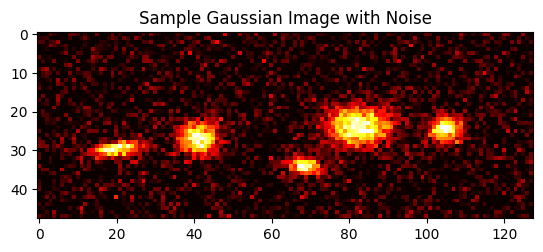

Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):
[[ 2.0181187e+01  2.9708189e+01  4.8006468e+00  1.1858233e+00
  -1.2722358e-01]
 [ 4.1283035e+01  2.7037781e+01  3.4765944e+00  2.9642999e+00
  -3.6785148e-02]
 [ 6.8435249e+01  3.4060810e+01  3.0155199e+00  1.5241636e+00
   1.6051035e-01]
 [ 8.2498222e+01  2.3888981e+01  5.8629718e+00  3.5257988e+00
   1.6294440e-02]
 [ 1.0496950e+02  2.4722235e+01  2.7915611e+00  2.3240309e+00
   2.0154707e-02]]


In [4]:
def generate_gaussian_blob(image_size, mean, cov, angle, noise_std=0.01):
    """
    Generate a single Gaussian blob on an image with added random noise.
    """
    x, y = np.meshgrid(np.linspace(0, image_size[0] - 1, image_size[0]),
                       np.linspace(0, image_size[1] - 1, image_size[1]))
    x -= mean[0]
    y -= mean[1]

    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)

    x_rot = cos_angle * x + sin_angle * y
    y_rot = -sin_angle * x + cos_angle * y

    exponent = (x_rot ** 2) / (2 * cov[0] ** 2) + (y_rot ** 2) / (2 * cov[1] ** 2)
    blob = np.exp(-exponent)

    # Add random noise centered around the Gaussian blob
    noise = np.random.normal(0, noise_std, blob.shape)
    blob += noise

    return blob

def convert_parameters(parameters):
    """
    Convert Gaussian parameters from (amplitude, x0, y0, sigma_x, sigma_y) to (mean_x, mean_y, cov_x, cov_y, theta).
    """
    A, x0, y0, sigma_x, sigma_y = parameters
    
    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y
    
    # Calculate theta from the covariance values
    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan2(2 * cov_x * cov_y, (cov_x**2 - cov_y**2))
    else:
        theta = 0.0
    
    return mean_x, mean_y, cov_x, cov_y, theta

def create_training_data(num_samples, image_size=(128, 48), num_blobs=5, noise_std=0.05):
    """
    Create training data with Gaussian blobs and noise for the YOLO-style model.
    """
    X = np.zeros((num_samples, image_size[1], image_size[0], 1), dtype=np.float32)
    y = np.zeros((num_samples, num_blobs, 5), dtype=np.float32)

    for i in range(num_samples):
        image = np.zeros((image_size[1], image_size[0]), dtype=np.float32)
        blob_params = []

        # Generate y-values within 20% of each other
        base_y = np.random.uniform(0.4 * image_size[1], 0.6 * image_size[1])
        y_values = np.random.uniform(base_y * 0.8, base_y * 1.2, num_blobs)

        # Generate evenly spaced x-values with slight variation
        x_values = np.linspace(0, image_size[0], num_blobs + 2)[1:-1]
        x_values += np.random.uniform(-5, 5, num_blobs)

        for j in range(num_blobs):
            mean_x = x_values[j]
            mean_y = y_values[j]
            cov_x = np.random.uniform(2, 6)
            cov_y = np.random.uniform(1, 5)
            theta = np.random.uniform(-10, 10) * np.pi / 180  # Cap rotation at 10 degrees

            blob = generate_gaussian_blob((image_size[0], image_size[1]), (mean_x, mean_y), (cov_x, cov_y), theta, noise_std)
            image += blob

            # Store parameters for the label
            blob_params.append((mean_x, mean_y, cov_x, cov_y, theta))

        # Convert parameters to labels
        for j in range(num_blobs):
            mean_x, mean_y, cov_x, cov_y, theta = blob_params[j]
            y[i, j, :] = [mean_x, mean_y, cov_x, cov_y, theta]

        X[i, :, :, 0] = np.clip(image, 0, 1)

    return X, y

num_samples = 1  # Number of training samples
X_train, y_train = create_training_data(num_samples, noise_std=0.05)

print("Generated dataset shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
plt.imshow(X_train[0].squeeze(), cmap='hot')
plt.title("Sample Gaussian Image with Noise")
plt.show()
print("Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):")
print(y_train[0])

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class CropLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(CropLayer, self).__init__(**kwargs)

    def call(self, inputs):
        image, crop_boxes = inputs
        batch_size = tf.shape(image)[0]
        num_boxes = tf.shape(crop_boxes)[1]
        crop_boxes = tf.reshape(crop_boxes, (batch_size * num_boxes, 4))  # Flatten the crop_boxes tensor
        box_indices = tf.range(batch_size)
        box_indices = tf.repeat(box_indices, repeats=num_boxes)
        
        cropped_images = tf.image.crop_and_resize(
            image, crop_boxes, box_indices, (20, 20)
        )
        
        return cropped_images

def build_cnn_with_gaussian_prediction(input_shape):
    # Input layer
    inputs = layers.Input(shape=input_shape)
   
    # Initial convolutions to process the full image
    x = layers.Conv2D(8, kernel_size=3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
   
    # Predict 5 crop areas
    crop_pred = layers.Conv2D(16, kernel_size=3, activation='relu', padding='same')(x)
    crop_pred = layers.Flatten()(crop_pred)
    crop_pred = layers.Dense(64, activation='relu')(crop_pred)
    crop_pred = layers.Dense(5 * 4, activation='sigmoid', name='crop_prediction')(crop_pred)
   
    # Reshape crop predictions to [batch_size, 5, 4] format
    crop_boxes = layers.Reshape((5, 4))(crop_pred)
   
    # Crop the original input image
    cropped_images = CropLayer()([inputs, crop_boxes])
   
    x = layers.Conv2D(12, kernel_size=3, strides=1, padding='same')(cropped_images)
    x = layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(98, activation='relu')(x)
    x = layers.Dense(52, activation='relu')(x)
    outputs = layers.Dense(5)(x)
    
    #got rid of crop_pred output
    model = Model(inputs=inputs, outputs=[outputs, crop_pred])
    return model

# Example usage
input_shape = (48, 128, 1)
model = build_cnn_with_gaussian_prediction(input_shape)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 24, 64, 8) │         80 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 12, 32, 8) │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 6, 16, 16) │      1,168 │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 3, 8, 16)  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 3, 8, 16)  │      2,320 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 384)       │          0 │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     24,640 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ crop_prediction     │ (None, 20)        │      1,300 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 5, 4)      │          0 │ crop_prediction[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ crop_layer_3        │ (None, 20, 20, 1) │          0 │ input_layer_3[0]… │
│ (CropLayer)         │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 20, 20,    │        120 │ crop_layer_3[0][… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │         80 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 20, 20,    │          0 │ batch_normalizat… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 10, 10,    │          0 │ re_lu_6[0][0]     │
│ (MaxPooling2D)      │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 10, 10,    │      3,488 │ max_pooling2d_14… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │         40 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 10, 10,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 5, 5, 32)  │          0 │ re_lu_7[0][0]   

 Total params: 117,147 (457.61 KB)

 Trainable params: 117,087 (457.37 KB)

 Non-trainable params: 60 (240.00 B)

X_train shape: (20000, 48, 128, 1)
y_train shape: (20000, 5, 5)
X_val shape: (5000, 48, 128, 1)
y_val shape: (5000, 5, 5)


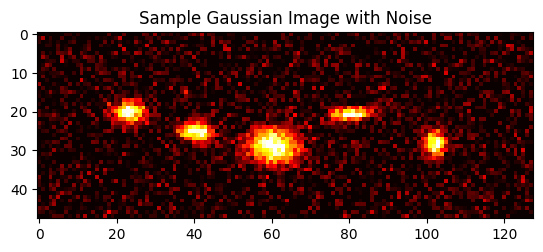

Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):
[[2.25867691e+01 2.18672123e+01 4.27955580e+00 3.78087211e+00
  1.25834897e-01]
 [4.15287476e+01 2.57512131e+01 4.54416227e+00 4.46435976e+00
  2.70455107e-02]
 [6.30347214e+01 2.65071926e+01 5.27295637e+00 4.36193514e+00
  1.68743119e-01]
 [8.57719498e+01 2.66469479e+01 3.15983105e+00 4.93630600e+00
  1.63180888e-01]
 [1.08100914e+02 2.45355682e+01 5.13593626e+00 1.18110299e+00
  6.10593241e-03]]


In [31]:
# Generate the training data
num_samples = 25000
X, y = create_training_data(num_samples)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 48, 128, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 128, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Visualize a sample image and its Gaussians
plt.imshow(X_train[0].squeeze(), cmap='hot')
plt.title("Sample Gaussian Image with Noise")
plt.show()

print("Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):")
print(y_val[0])

In [33]:
def gaussian_loss(y_true, y_pred):
    # Reshape y_true and y_pred to ensure compatibility
    y_true = tf.reshape(y_true, [-1, 5, 1])
    y_pred = tf.reshape(y_pred, [-1, 5, 1])

    # Separate the true and predicted parameters
    true_meanx, true_meany, true_covx, true_covy, true_theta = tf.split(y_true, 5, axis=1)
    pred_meanx, pred_meany, pred_covx, pred_covy, pred_theta = tf.split(y_pred, 5, axis=1)

    # Compute the Mean Squared Error for each parameter
    meanx_loss = tf.reduce_mean(tf.square(true_meanx - pred_meanx) / 127.0)
    meany_loss = tf.reduce_mean(tf.square(true_meany - pred_meany) / 48.0)
    covx_loss = tf.reduce_mean(tf.square(true_covx - pred_covx) / 6.0)
    covy_loss = tf.reduce_mean(tf.square(true_covy - pred_covy) / 5.0)
    theta_loss = tf.reduce_mean(tf.square(true_theta - pred_theta) / 0.175)

    # Weighted sum of the losses
    loss = meanx_loss + meany_loss + covx_loss + covy_loss + theta_loss
    
    return loss

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model = build_cnn_with_gaussian_prediction(input_shape)

model.compile(optimizer='adam', loss = gaussian_loss)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11.9141

W0000 00:00:1723095209.799978 1004465 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -4 } dim { size: 48 } dim { size: 128 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -2 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 20 } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2999 num_cores: 32 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 134217728 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size

625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 11.8759 - val_loss: 0.7875 - learning_rate: 0.0010
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.7912 - val_loss: 0.6218 - learning_rate: 0.0010
Epoch 3/200
341/625 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.6150

KeyboardInterrupt: 

In [25]:
X_test, y_test = create_training_data(1)
y_pred = model.predict(X_test)
print(y_test.shape)
y_pred = y_pred[0]
y_test = tf.squeeze(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(1, 5, 5)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_gaussians_from_predictions(predictions, image_shape=(48, 128), threshold=0.1):
    # Create an empty image
    image = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)

    for i in range(predictions.shape[0]):  # Iterate over each prediction
        meanx, meany, covx, covy, theta = predictions[i]
        meanx, meany = meanx * image_shape[1] / 128, meany * image_shape[0] / 48  # Scale coordinates

        # Only plot if covx and covy are noticeably above the threshold
        if covx > threshold and covy > threshold:
            # Draw the Gaussian blob on the image
            draw_blob(image, meanx, meany, covx, covy, theta)

    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.title('Generated Gaussians from Predictions')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.show()

def draw_blob(image, meanx, meany, covx, covy, theta):
    center = (int(meanx), int(meany))
    axes = (int(2 * covx), int(2 * covy))  # 2 standard deviations
    angle = np.degrees(theta)
    color = (0, 0, 255)  # Red color
    thickness = 2

    # Draw the ellipse on the image
    cv2.ellipse(image, center, axes, angle, 0, 360, color, thickness)

tf.Tensor(
[[ 2.0888630e+01  2.1224100e+01  3.9726787e+00  1.9531502e+00
  -6.6204488e-02]
 [ 4.3970486e+01  2.2254221e+01  4.6018429e+00  3.4758880e+00
   5.4013643e-02]
 [ 6.3183403e+01  2.0170593e+01  2.0548818e+00  2.1706598e+00
  -3.4432422e-02]
 [ 8.7631226e+01  2.4967325e+01  2.5106649e+00  2.6673508e+00
   1.2878633e-01]
 [ 1.0765682e+02  1.8068958e+01  5.7920370e+00  1.8770424e+00
  -1.5315430e-02]], shape=(5, 5), dtype=float32)


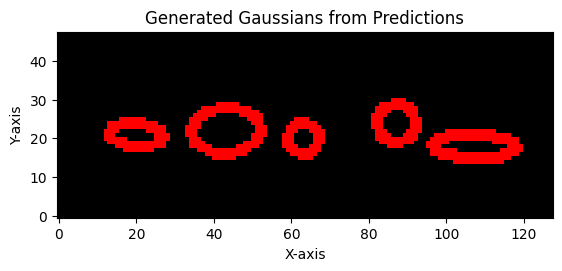

In [27]:
print(y_test)
plot_gaussians_from_predictions(y_test)

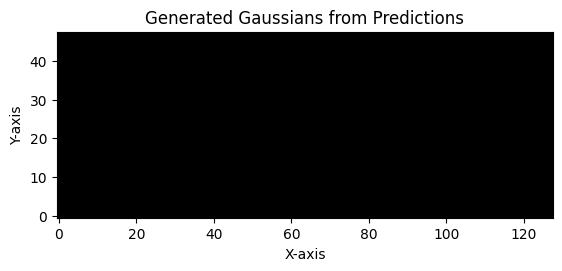

In [28]:
plot_gaussians_from_predictions(y_pred)

ValueError: setting an array element with a sequence.

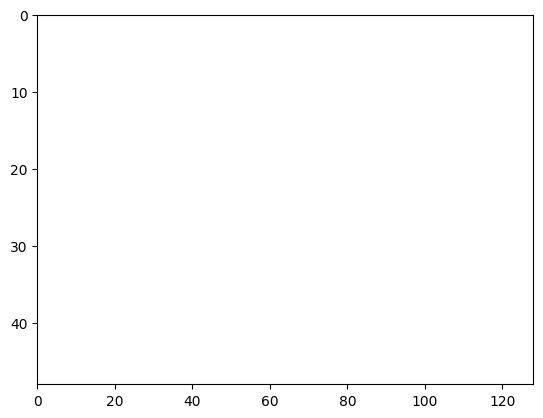

In [27]:
plot_gaussian_blobs(y_test)